<a href="https://colab.research.google.com/github/stanislavfort/exploring_the_limits_of_OOD_detection/blob/main/ViT_for_strong_near_OOD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
conda create -p $(pwd)/conda_env python=3.9
conda activate conda_env/
pip install jupyter
pip install -r vision_transformer/vit_jax/requirements.txt
pip install numpy==1.22.4

pip uninstall jax jaxlib
# conda install nvidia/label/cuda-12.0.1::cuda
# conda install nvidia/label/cuda-12.4.0::cuda
conda install anaconda::cudnn=8.9.2.26   # CUDA 11.0  INSTALLED ON SYSTEM
git clone https://github.com/google/jax
cd jax
git checkout jax-v0.2.6
# export LD_LIBRARY_PATH="$CONDA_PREFIX/lib"
pip install scipy==1.7.3
# for n in $(ls -d $CONDA_PREFIX/targets/x86_64-linux/include/*); do if ! [ -e "$CONDA_PREFIX"/include/$(basename $n) ]; then ln -s "$n" "$CONDA_PREFIX/include"; fi; done
# for n in $(ls -d /mnt/homeGPU/cpelaez/Collaborations/novelty_detection/sota/TEMP/exploring_the_limits_of_OOD_detection/conda_env_build/nsight-compute-2024.1.1/host/target-linux-x64/*); do if ! [ -e "$CONDA_PREFIX"/lib/$(basename $n) ]; then ln -s "$n" "$CONDA_PREFIX/lib"; fi; done
python build/build.py --enable_cuda --cudnn_path="$CONDA_PREFIX"
pip install .   # Install JAX
cd build
pip install .   # Install JAXLIB
cd ../..

pip uninstall tensorflow-cpu
pip install tensorflow[and-cuda]==2.7.0 tf-keras
pip install protobuf==3.20.1
pip install tensorflow_probability==0.12.0
pip install seaborn
pip install scikit-learn
pip install scipy==1.7.3
pip install matplotlib==3.7.5
pip install typing-extensions --upgrade

pip install scipy==1.7.3
pip install numpy==1.22.4



export PATH="$CONDA_PREFIX/lib/python3.9/site-packages/nvidia/cuda_nvcc/bin:$PATH"
export PYTHONPATH='vmmrdb_datasets'
jupyter-notebook --ip='*'
```

# Replicating the use of ViT for near out-of-distributution detection from
# **Exploring the Limits of Out-of-Distribution Detection** 
by Stanislav Fort, Jie Ren, Balaji Lakshminarayanan

This is Colab performs a key experiments from [Exploring the Limits of Out-of-Distribution Detection](https://arxiv.org/abs/2106.03004), [accepted at NeurIPS 2021](https://proceedings.neurips.cc/paper/2021/hash/3941c4358616274ac2436eacf67fae05-Abstract.html). It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs). 

This Colab is heavily inspired by the the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection. 

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.

You should expect to see the following plots:

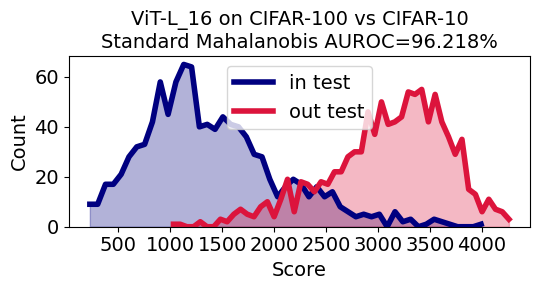

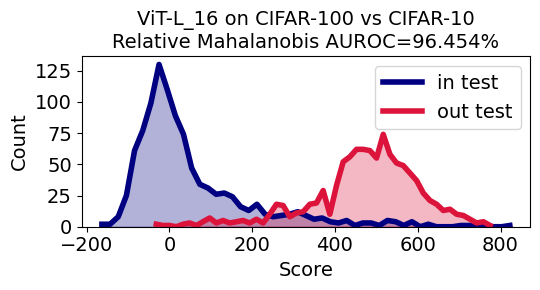

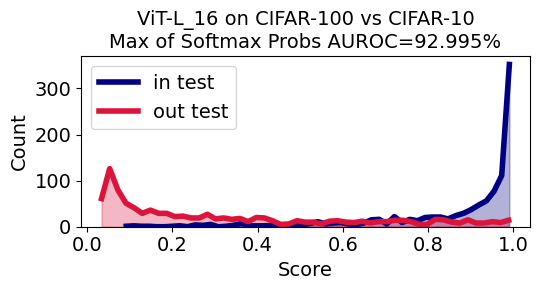

# Imports and loading

In [1]:
import numpy as np

In [2]:
! ptxas --version

ptxas: NVIDIA (R) Ptx optimizing assembler
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:08:00_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [3]:
![ -d vision_transformer ] 
!pwd

/mnt/homeGPU/cpelaez/Collaborations/novelty_detection/sota/TEMP/exploring_the_limits_of_OOD_detection


In [3]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone https://github.com/google-research/vision_transformer

In [4]:
! cd vision_transformer && git checkout ed1491238f5ff6099cca81087c575a215281ed14

M	vit_jax/models.py
HEAD is now at ed14912 Adds code for "How to train your ViT? ..." paper.


In [5]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

In [4]:
!ls vision_transformer/vit_jax/

checkpoint.py		__init__.py	   models_resnet.py  test_utils.py
checkpoint_test.py	input_pipeline.py  models_test.py    train.py
configs			main.py		   momentum_clip.py  train_test.py
inference_time.py	models_mixer.py    __pycache__	     utils.py
inference_time_test.py	models.py	   requirements.txt


In [6]:
# fetch out repository to get the modified models.py file with the pre-logits extraction
!git clone --depth=1 https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection

Cloning into 'exploring_the_limits_of_OOD_detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), done.


In [7]:
!rm vision_transformer/vit_jax/models.py
!cp exploring_the_limits_of_OOD_detection/models.py vision_transformer/vit_jax/

In [2]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [3]:
!nvidia-smi

Wed Sep 11 13:53:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:B7:00.0 Off |                    0 |
| N/A   37C    P0              52W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


In [5]:
tf.config.list_physical_devices('GPU')

2024-09-11 13:53:44.327529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2024-09-11 13:53:44.327569: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [7]:
#selecting a ViT checkpoint

tfds_name = 'vmmrdb_brand'
tfds_ood_name = f'{tfds_name}_ood'
model_name = 'ViT-L_16'
step = 665
resolution = 384
model_config = models_config.AUGREG_CONFIGS[model_name.split('-')[-1]]
path = f'./{model_name}_{tfds_name}_{step}.npz'

print(path)

./ViT-L_16_vmmrdb_brand_665.npz


In [8]:
tf.io.gfile.stat(path)

In [9]:
import tensorflow_datasets as tfds
import vmmrdb_brand.vmmrdb_brand_dataset_builder

ds_in, ds_in_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_in_info

tfds.core.DatasetInfo(
    name='vmmrdb_brand',
    full_name='vmmrdb_brand/1.0.0',
    description="""
    
    """,
    homepage='https://github.com/faezetta/VMMRdb',
    data_dir='/home/cpelaez/tensorflow_datasets/vmmrdb_brand/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=11.75 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=50),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'ood_test': <SplitInfo num_examples=242, num_shards=1>,
        'test': <SplitInfo num_examples=99695, num_shards=64>,
        'train': <SplitInfo num_examples=170907, num_shards=64>,
        'val': <SplitInfo num_examples=14242, num_shards=8>,
    },
    citation="""""",
)

In [10]:
import tensorflow_datasets as tfds
import vmmrdb_brand_ood.vmmrdb_brand_ood_dataset_builder

ds_out, ds_out_info = tfds.load(tfds_ood_name, with_info=True,batch_size=128)
ds_out_info

tfds.core.DatasetInfo(
    name='vmmrdb_brand_ood',
    full_name='vmmrdb_brand_ood/1.0.0',
    description="""
    
    """,
    homepage='https://github.com/faezetta/VMMRdb',
    data_dir='/home/cpelaez/tensorflow_datasets/vmmrdb_brand_ood/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=9.97 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=25),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'ood_test': <SplitInfo num_examples=242, num_shards=1>,
    },
    citation="""""",
)

In [11]:
model_config

classifier: token
hidden_size: 1024
name: ViT-L_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 4096
  num_heads: 16
  num_layers: 24

In [13]:
# Get a clean model
model = models.VisionTransformer(
    num_classes=ds_in_info.features['label'].num_classes, **model_config)

In [14]:
# Load a checkpoint from cloud
# takes a while for a big model
params = checkpoint.load(path)

In [15]:
# out modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_in_info.features['label'].num_classes, **model_config)

# Getting unaugmented datasets

In [16]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

In [142]:
import tensorflow_datasets as tfds 
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=False)

  return ds_in

In [143]:
batch_size = 128

ds_in_train = prepare_pure_dataset(tfds.load(tfds_name, split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
ds_in_test = prepare_pure_dataset(tfds.load(tfds_name, split='ood_test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
ds_out_test = prepare_pure_dataset(tfds.load(tfds_ood_name, split='ood_test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

In [144]:
ds_in_test

<BatchDataset shapes: {image: (None, 384, 384, 3), label: (None,)}, types: {image: tf.float32, label: tf.int64}>

In [94]:
tfds_ood_name

'vmmrdb_brand_ood'

In [145]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(ds_in_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(ds_out_test)
print(min_now,mean_now,max_now)

0.0 0.42443195 1.0
0.0 0.42141998 1.0


2024-09-12 07:48:11.733512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Prelogits extraction

## Extractor

In [25]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [68]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 150000
N_test = 1000

assert N_train <= 150000
assert N_test <= 10000

### In-Distribution test (X minutes)

In [146]:
ds_in_test_prelogits, ds_in_test_logits, ds_in_test_labels = standalone_get_prelogits(
    params, 
    ds_in_test, 
    image_count=N_test
    )

Images done=128 time remaining=46s
Images done=242 time remaining=63s


### In-Distribution train (X minutes)

In [69]:
ds_in_train_prelogits, ds_in_train_logits, ds_in_train_labels = standalone_get_prelogits(
    params,
    ds_in_train,
    image_count=N_train
    )

Images done=128 time remaining=8035s
Images done=256 time remaining=8007s
Images done=384 time remaining=7812s
Images done=512 time remaining=7872s
Images done=640 time remaining=7826s
Images done=768 time remaining=7788s
Images done=896 time remaining=7808s
Images done=1024 time remaining=7781s
Images done=1152 time remaining=7807s
Images done=1280 time remaining=7799s
Images done=1408 time remaining=7820s
Images done=1536 time remaining=7802s
Images done=1664 time remaining=7805s
Images done=1792 time remaining=7786s
Images done=1920 time remaining=7794s
Images done=2048 time remaining=7782s
Images done=2176 time remaining=7780s
Images done=2304 time remaining=7762s
Images done=2432 time remaining=7747s
Images done=2560 time remaining=7755s
Images done=2688 time remaining=7739s
Images done=2816 time remaining=7741s
Images done=2944 time remaining=7719s
Images done=3072 time remaining=7719s
Images done=3200 time remaining=7695s
Images done=3328 time remaining=7692s
Images done=3456 ti

### Out-of-Distribution test (X minutes)

In [147]:
ds_out_test_prelogits, ds_out_test_logits, ds_out_test_labels = standalone_get_prelogits(
    params, 
    ds_out_test, 
    image_count=N_test
    )

Images done=128 time remaining=45s
Images done=242 time remaining=38s


## Accuracies

In [148]:
# checking the accuracy on CIFAR-100

finetune_train_acc = np.mean(
    np.argmax(ds_in_train_logits,axis=-1) == ds_in_train_labels
    )

finetune_test_acc = np.mean(
    np.argmax(ds_in_test_logits,axis=-1) == ds_in_test_labels
    )

print(f"{tfds_name} train accuracy = "+str(finetune_train_acc))
print(f"{tfds_name} test accuracy = "+str(finetune_test_acc))

vmmrdb_brand train accuracy = 0.7093043408703071
vmmrdb_brand test accuracy = 0.7148760330578512


# Computing near-OOD AUROC

In [149]:
ds_in_train_embeds = ds_in_train_prelogits
ds_in_y_train = ds_in_train_labels
ds_in_train_preds = ds_in_train_logits

ds_in_test_embeds = ds_in_test_prelogits
ds_in_y_test = ds_in_test_labels
ds_in_test_preds = ds_in_test_logits

ds_out_test_embeds = ds_out_test_prelogits
ds_out_y_test = ds_out_test_labels
ds_out_test_preds = ds_out_test_logits

## Computing Mahalanobis means and covariances

In [33]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [128]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  # print(indist_test_embeds_in_touse[indist_test_embeds_in_touse[:, 0].argsort()][-1][0], outdist_test_embeds_in_touse[outdist_test_embeds_in_touse[:, 0].argsort()][-1][0])
  indist_test_embeds_in_touse = indist_test_embeds_in_touse[indist_test_embeds_in_touse[:, 0].argsort()]
  outdist_test_embeds_in_touse = outdist_test_embeds_in_touse[outdist_test_embeds_in_touse[:, 0].argsort()]

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    # print(indist_train_embeds_in_touse[indist_train_labels_in == c].shape)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  
  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [35]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [150]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(ds_in_train_embeds)[:,:],
        ds_in_y_train,
        np.array(ds_in_test_embeds)[:,:],
        np.array(ds_out_test_embeds)[:,:],
        indist_classes=ds_in_info.features['label'].num_classes,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [151]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = ds_in_test_embeds

outdist_test_embeds = ds_out_test_embeds

indist_dists = []
for c in range(ds_in_info.features['label'].num_classes):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(ds_in_info.features['label'].num_classes):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [152]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [153]:
print("In-Distribution score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("Out-of-Distribution score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

In-Distribution score = 1150.439458887542+-360.49826898509804
Out-of-Distribution score = 1509.0653422640517+-571.2621430235619


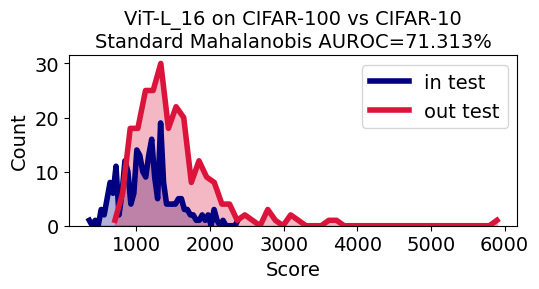

In [154]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

## Relative Mahalanobis distance

In [155]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [156]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(ds_in_train_embeds)[:,:],
        ds_in_y_train,
        np.array(ds_in_test_embeds)[:,:],
        np.array(ds_out_test_embeds)[:,:],
        indist_classes=ds_in_info.features['label'].num_classes,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )

In [157]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [158]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [159]:
print("In-Distribution score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("Out-of-Distribution score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

In-Distribution score = 47.593458937304646+-104.9481741678653
Out-of-Distribution score = -31.3916842207827+-111.83888409155887


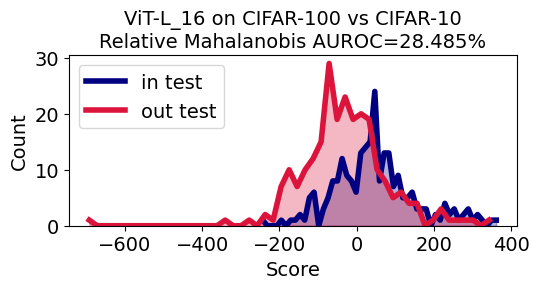

In [160]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

## Max of Softmax Probabilities score

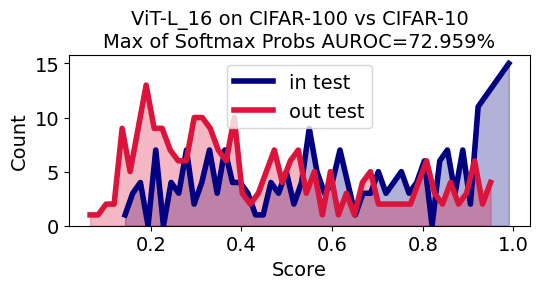

In [161]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(ds_in_test_logits),axis=-1),
     np.max(np_softmax(ds_out_test_logits),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(ds_in_test_logits)+[0]*len(ds_out_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )